Things to do: 

1. Push to github


1. Understand the effect of the mapping 


1. Do the another model?

1. (Maybe taxi rides, Maybe the other things)




Doing more ???

1. Push further:

In [1]:

%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
import jax.random as jrandom
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
from typing import NamedTuple, Mapping
from tensorflow_probability.substrates import jax as tfp
from advi import *
from models import *
bijectors = tfp.bijectors
sigmoid_transform = bijectors.IteratedSigmoidCentered()

In [2]:
class Model(NamedTuple):
    dim: int
    log_prior: Mapping
    log_likelyhood: Mapping
    t_inv_map: Mapping
    jac_t_inv_map: Mapping
    log_det_jac_t_inv_map: Mapping

In [6]:
def mean_field_obj(param, sample, model):
    mu = param["mu"]
    sigma = param["sigma"]
    sample = sample * sigma + mu
    log_likelyhood = model.log_likelyhood(sample)
    log_prior = model.log_prior(sample)
    log_det_jac = jnp.abs(model.log_det_jac_t_inv_map(sample))
    entropy = 0.5 * jnp.sum(jnp.log((2 * jnp.pi * jnp.e) * sigma**2))
    return log_likelyhood + log_prior + log_det_jac + entropy

mean_field_grad = jax.grad(mean_field_obj, argnums=0)
mean_field_grad_val = jax.value_and_grad(mean_field_obj, argnums=0)
v_mean_field_grad_val = jax.vmap(
    mean_field_grad_val,
    in_axes=(None, 0, None),
    out_axes=(0, {"mu": 0, "sigma": 0}),
)

@jax.jit
def adaptive_step_size(iter, s_k, grads, stepsize=0.5, momentum=0.1, tau=1):
    s_kplus = jax.tree_map(
        lambda x, y: momentum * x**2 + (1 - momentum) * y, grads, s_k
    )
    lead_const = stepsize * (iter + 1) ** (-0.5 + 1e-6)
    rho_k = jax.tree_map(lambda x: lead_const / (tau + x), s_kplus)
    return rho_k, s_kplus


@jax.jit
def sgd_update_params(params, new_params, step_size):
    return jax.tree_map(lambda x, y, z: x + z * y, params, new_params, step_size)


class mean_field_advi:
    def __init__(self, model: Model) -> None:
        self.model = model
        self.params = {
            "mu": jnp.zeros((self.model.dim,)) * 1.0,
            "sigma": jnp.ones((self.model.dim,)) * 1.0,
        }
        self.old_params_grad = jax.tree_map(lambda x: jnp.zeros_like(x), self.params)
        self.obj_fun = mean_field_obj
        self.grad_fun = jax.grad(mean_field_grad)

    def sgd_update_params(self, params, new_params, step_size):
        return jax.tree_map(lambda x, y, z: x + z * y, params, new_params, step_size)

    def run_advi(
        self,
        key,
        num_sample,
        num_iter,
        learning_rate,
        print_every=100,
        alpha=0.1,
        adaptive=False,
    ):
        loss_val = []
        jit_wrapper = lambda x, y: v_mean_field_grad_val(x, y, self.model)
        val_grad = jax.jit(jit_wrapper)
        for i in range(num_iter):
            key, _ = jrandom.split(key)
            samples = jrandom.normal(key, shape=(num_sample, self.model.dim))
            vals, grads = val_grad(self.params, samples)

            loss_val.append(jnp.mean(vals))
            mean_grad = jax.tree_map(lambda x: jnp.mean(x, axis=0), grads)
            if adaptive:
                if i == 0:
                    s_k = jax.tree_map(lambda x: x**2, mean_grad)
                step_size, s_k = adaptive_step_size(
                    i, s_k, mean_grad, stepsize=learning_rate, momentum=alpha
                )

            step_size = jax.tree_map(
                lambda x: learning_rate * jnp.ones(x.shape), self.params
            )
            self.params = sgd_update_params(self.params, mean_grad, step_size)

            if i % print_every == 0:
                print(loss_val[-1])
                # break
        return loss_val
    
    def sample(self, key):
        sample = jrandom.normal(key, shape=(self.model.dim,))*self.params['sigma']+self.params['mu']
        return self.model.t_inv_map(sample)

In [12]:
def LinearModel(X, y, a_zero, b_zero):
    dim = X.shape[1] + 1

    def t_inv_map(param):
        # Mapping from R^d to R^{d-1} \times R_{++}
        return param[: dim - 1], jnp.exp(param[dim - 1])

    def log_prior(param):
        w, sigma = t_inv_map(param)
        log_w_proba = jnp.sum(stats.norm.logpdf(w, 0, sigma))
        log_sigma_proba = stats.gamma.logpdf(sigma / a_zero, b_zero) - jnp.log(a_zero)
        return log_w_proba + log_sigma_proba

    def log_likelyhood(param):
        w, sigma = t_inv_map(param)
        preds = X @ w
        proba = jnp.sum(stats.norm.logpdf(y, preds, sigma))
        return proba

    def log_det_jac_t_inv_map(param):
        return jnp.sum(jnp.log(jnp.abs(jnp.diagonal(jac_t_inv_map(param)))))

    def jac_t_inv_map(param):
        to_return = jnp.eye(dim)
        to_return = to_return.at[dim - 1, dim - 1].set(jnp.exp(param[dim - 1]))
        return to_return

    return Model(
        dim=dim,
        log_prior=log_prior,
        log_likelyhood=log_likelyhood,
        t_inv_map=t_inv_map,
        jac_t_inv_map=jac_t_inv_map,
        log_det_jac_t_inv_map=log_det_jac_t_inv_map,
    )


def NMF_Model_PoissonGamma(
    data, rank, gamma_prior_shape, gamma_prior_scale
):
    num_samples, num_dims = data.shape
    dim = num_samples * rank + rank * num_dims

    def t_inv_map(params):
        theta, beta = jnp.split(params, [num_samples * rank])
        theta = jnp.reshape(theta, (num_samples, rank))
        beta = jnp.reshape(beta, (rank, num_dims))
        theta = jnp.exp(theta + 1)
        beta = jnp.exp(beta + 1)
        return theta, beta
    
    def jac_t_inv_map(params):
        return jnp.diag(jnp.exp(params + 1))

    def log_det_jac_t_inv_map(params):
        return jnp.sum(jnp.log(jnp.exp(params + 1)))

    def log_prior(params):
        theta, beta = t_inv_map(params)
        # theta_prior = stats.expon.logpdf(theta,exp_prior)
        theta_prior = stats.gamma.logpdf(
            theta/gamma_prior_scale, gamma_prior_shape) - jnp.log(gamma_prior_scale)
        beta_prior = stats.gamma.logpdf(
            beta/gamma_prior_scale, gamma_prior_shape) - jnp.log(gamma_prior_scale)
        return jnp.sum(theta_prior) + jnp.sum(beta_prior)

    def log_likelyhood(params):
        theta, beta = t_inv_map(params)
        reconst = theta @ beta
        log_like = stats.poisson.logpmf(data, reconst)
        return jnp.sum(log_like)

    return Model(
        dim=dim,
        log_prior=log_prior,
        log_likelyhood=log_likelyhood,
        t_inv_map=t_inv_map,
        jac_t_inv_map=jac_t_inv_map,
        log_det_jac_t_inv_map=log_det_jac_t_inv_map,
    )
    
def NMF_Model_PoissonDirExp(
    data, rank,dir_prior=1,exp_prior=4
):
    num_samples, num_dims = data.shape
    dim = (num_samples-1)* rank + rank * num_dims

    def t_inv_map(params):
        theta, beta = jnp.split(params, [(num_samples-1)* rank])
        theta = jnp.reshape(theta, (num_samples-1, rank))
        beta = jnp.reshape(beta, (rank, num_dims))
        theta = sigmoid_transform.forward(theta.T).T
        beta = jnp.log(jnp.exp(beta)+1)
        return theta, beta
    
    def jac_t_inv_map(params):
        raise NotImplemented

    def log_det_jac_t_inv_map(params):
        theta , beta = jnp.split(params, [(num_samples-1)* rank])
        theta = jnp.reshape(theta, (num_samples-1, rank))
        log_det = jnp.sum(sigmoid_transform.forward_log_det_jacobian(theta.T))
        det = jnp.sum(jnp.log(1/(1+jnp.exp(-beta))))
        return log_det+det

    def log_prior(params):
        theta, beta = t_inv_map(params)
    
        theta_prior = jnp.log(stats.dirichlet.pdf(theta, jnp.full(shape=(num_samples,),fill_value=dir_prior)))
        beta_prior = jnp.sum(stats.expon.logpdf(beta, scale=exp_prior))
        return jnp.sum(theta_prior)+ jnp.sum(beta_prior)

    def log_likelyhood(params):
        theta, beta = t_inv_map(params)
        reconst = theta @ beta
        log_like = stats.poisson.logpmf(data, reconst)
        return jnp.sum(log_like)

    return Model(
        dim=dim,
        log_prior=log_prior,
        log_likelyhood=log_likelyhood,
        t_inv_map=t_inv_map,
        jac_t_inv_map=jac_t_inv_map,
        log_det_jac_t_inv_map=log_det_jac_t_inv_map,
    )

In [13]:
N = 100
d = 3
key = jrandom.key(42)
k1, k2, k3 = jrandom.split(key, 3)
X_data = jrandom.normal(k1, shape=(N, d))
w_star = jrandom.normal(k2, shape=(d,)) * 2
y = X_data @ w_star
linear_model = LinearModel(X_data, y, 1, 1)
linear_advi = mean_field_advi(linear_model)
key = jrandom.key(52)
loss = linear_advi.run_advi(key, 100, 1001, 1e-4, print_every=500, adaptive=True, alpha=0.5)
print("Sample ", linear_advi.sample(k3)[0])
print("True value", w_star)

-2103.9502
-157.28076
-27.707773
Sample  [-2.0109599 -1.756732  -1.3096539]
True value [-2.0137007 -1.7523379 -1.3056182]


In [14]:
from scipy.io import loadmat
all_data = loadmat("data/frey_rawface.mat")
data = all_data["ff"].T 

-48870076.0
-9934027.0
-7818116.0
-7223305.0
-6996813.0
-6914079.0
-6884195.5
-6870013.0
-6855159.5
-6814287.5
-6694778.0


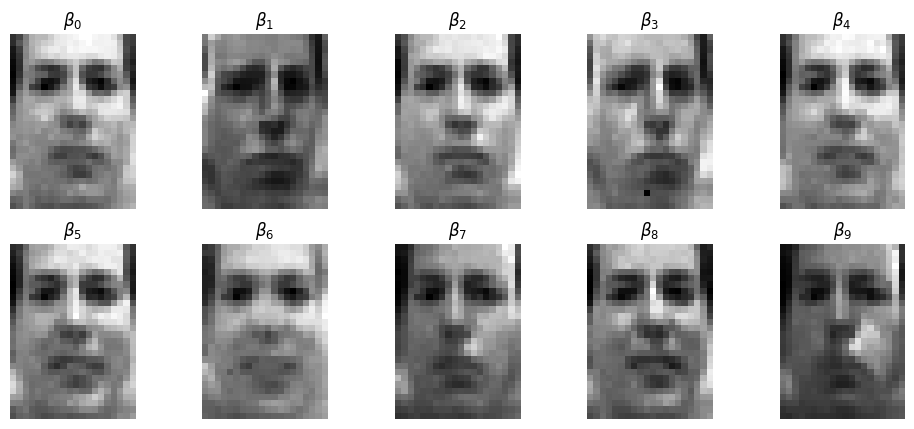

In [17]:
rank = 10
nmf_model = NMF_Model_PoissonGamma(
    data, rank, gamma_prior_shape=1, gamma_prior_scale=1
)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 3, 5001, 1e-6, print_every=500, adaptive=True)


thetas,betas  = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(rf"$\beta_{{{i}}}$")

-1675961300.0
-1253895300.0
-1189567600.0
-1153612800.0
-1128470400.0
-1108975400.0
-1093352400.0
-1080028200.0
-1068537660.0
-1058423940.0
-1049379800.0
-1041229100.0
-1033791300.0
-1026953000.0
-1020604000.0
-1014697800.0
-1009196540.0
-1004074000.0
-999127500.0
-994540540.0
-990129660.0
-985994200.0
-982034900.0
-978233540.0
-974660200.0
-971176260.0
-967840600.0
-964618200.0
-961517200.0
-958561800.0
-955647800.0
-952850600.0
-950150800.0
-947551040.0
-945026700.0
-942559700.0
-940172400.0
-937822700.0
-935566800.0
-933310660.0
-931271100.0
-929144000.0
-927083840.0
-925056000.0
-923115500.0
-921246140.0
-919360960.0
-917504830.0
-915706050.0
-913985700.0
-912254460.0


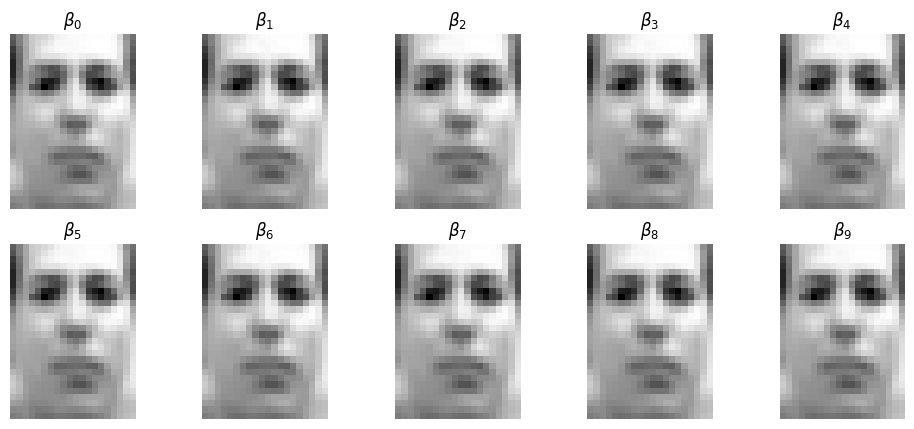

In [21]:
rank = 10
nmf_model = NMF_Model_PoissonDirExp(data, rank)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 10, 5001, 1e-5, print_every=100, adaptive=True)


thetas,betas  = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(rf"$\beta_{{{i}}}$")

theta_25: [3.284535  2.9023647 3.25324   3.151415  3.4009838 3.2777112 3.1394155
 3.2927613 3.4886453 3.6560411]


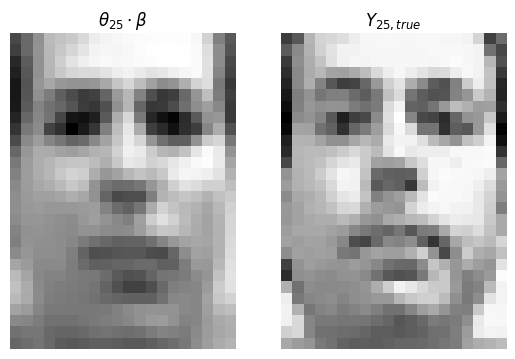

In [36]:
u = 25
plt.figure()
plt.subplot(121)
plt.imshow((thetas[u] @ betas).reshape(28, 20), cmap="gray")
plt.axis("off")
plt.title(rf"$\theta_{{{u}}}\cdot\beta$")
plt.subplot(122)
plt.imshow((data[u]).reshape(28, 20), cmap="gray")
plt.title(rf"$Y_{{{u}, true}}$")
plt.axis("off")
print(f"theta_{u}: {thetas[u]}")